# Phenolopy

## Initialise phenolopy

### Load packages

In [4]:
%matplotlib inline
%load_ext autoreload

import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import datacube
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, wiener
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL as stl
from datacube.drivers.netcdf import write_dataset_to_netcdf

sys.path.append('../Tools/dea_tools')
from datahandling import load_ard
from dea_dask import create_local_dask_cluster
from plotting import display_map, rgb

sys.path.append('./scripts')
import phenolopy
from phenolopy import *

### Set up a dask cluster

In [5]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/afche18@gmail.com/proxy/8787/status,
Dashboard: /user/afche18@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43499,Workers: 1
Dashboard: /user/afche18@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:46347,Total threads: 2
Dashboard: /user/afche18@gmail.com/proxy/46009/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43931,


In [6]:
# open up a datacube connection
dc = datacube.Datacube(app='phenolopy')

## Study area and data setup

### Set study area and time range

In [4]:
# set lat, lon (y, x) dictionary of testing areas for gdv project
loc_dict = {
    'test_a':   (-23.28043, 119.85931),
    'test_b':   (-31.60693, 116.94264)
}

# set buffer length and height (x, y)
buff_dict = {
    'test_a': (0.05, 0.05),
    'test_b': (0.05, 0.05),
}

In [5]:
# select location from dict
study_area = 'test_a'

# set buffer size in lon, lat (x, y)
lon_buff, lat_buff = buff_dict[study_area][0], buff_dict[study_area][1]

# select start and end year range. for one year, set same year -01 for start and -12 for end. multiple years will be averaged. 
time_range = ('2021-01', '2021-12')

In [6]:
# select a study area from existing dict
lat, lon = loc_dict[study_area][0], loc_dict[study_area][1]

# combine centroid with buffer to form study boundary
lat_extent = (lat - lat_buff, lat + lat_buff)
lon_extent = (lon - lon_buff, lon + lon_buff)

# display onto interacrive map
# display_map(x=lon_extent, y=lat_extent)

## Load local modis data

In [7]:
from glob import glob
import rasterio as rio

In [8]:
# os.listdir("./data")
raster_files = glob("./data/*.tif")
raster_files.sort()
raster_files[0:2]

['./data/MOD13Q1_NDVI_2016_001.tif', './data/MOD13Q1_NDVI_2016_017.tif']

In [9]:
# src = rio.open(raster_files[0])

In [10]:
# data = src.read(1)

In [11]:
# src.meta

In [12]:
# fp = raster_files[0]
# fp = fp.strip(".tif")
# fp = fp.strip("/data/")
# source, variable, year, day = fp.split("_")
# fp

In [13]:
# ds = xr.open_dataset(raster_files[0])
# ds

In [14]:
# ds.rename({'band_data':variable.lower()})

In [15]:
# ds = ds.assign_coords(time=[year+"_"+day])
# idx = 0
# ds['band'] = [idx]
## ds = ds.assign_coords(time=year+"_"+day)

## Load all

In [27]:
def load_modis(fp, idx):
    ds = xr.open_dataset(fp)
    fp = fp.strip(".tif")
    fp = fp.strip("/data/")
    source, variable, year, day = fp.split("_")
    date = datetime.strptime(year + "-" + day, "%Y-%j")
    # ds = ds.assign_coords(time=[year+"_"+day])
    ds = ds.rename({'band': 'time'})
    ds = ds.assign_coords(time=[date])
    # ds['band'] = [idx]
    ds = ds.rename({'band_data':variable.lower()})
    # ds = ds.drop('band')
    return ds

In [28]:
datasets = [load_modis(fp, i) for i, fp in enumerate(raster_files)]

In [31]:
# ds = datasets[0].copy()
# ds

In [39]:
ds = xr.concat(datasets, dim='time')

In [40]:
ds

<xarray.Dataset>
Dimensions:      (x: 39, y: 39, time: 46)
Coordinates:
  * x            (x) float64 4.899e+05 4.902e+05 ... 4.992e+05 4.994e+05
  * y            (y) float64 6.508e+06 6.508e+06 ... 6.499e+06 6.498e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2016-01-01 2016-01-17 ... 2018-12-03
Data variables:
    ndvi         (time, y, x) float32 37.0 38.0 32.0 35.0 ... 63.0 61.0 59.0

In [38]:
# ds = xr.merge(datasets)

In [96]:
# crs = "EPSG:4326"
# ds = add_crs(ds, crs)

In [111]:
# ds = xr.open_mfdataset(raster_files, combine="nested", compat='override')

In [57]:
# ds = ds.rio.set_crs("EPSG:4326")

In [64]:
# ds.rio.transform()

Affine(250.0, 0.0, 489785.2,
       0.0, -250.0, 6507974.4)

In [ ]:
# ds

In [ ]:
data = ds.sel(band=1)['band_data']

In [ ]:
import os
import ipyleaflet
import numpy as np
from ipywidgets import widgets as w
from IPython.display import display

import datacube
import odc.ui
from odc.ui import with_ui_cbk

import sys
# sys.path.insert(1, '../Tools/')
from dea_tools.maps import folium_map
from dea_tools.maps import ipyleaflet_map

In [84]:
# rgb_ows_cfg = {
#     "components": {
#         "red": {"nbart_red": 1.0},
#         "green": {"nbart_green": 1.0},
#         "blue": {"nbart_blue": 1.0},
#     },
#     "scale_range": (50, 3000),
# }
# folium_map(ds, ows_style_config=rgb_ows_cfg, width=600, height=600)

### Load sentinel-2a, b data for above parameters

In [35]:
# load_ard?

In [40]:
# set measurements (bands)
measurements = [
    'nbart_blue',
    'nbart_green',
    'nbart_red',
    'nbart_nir_1',
    'nbart_swir_2'
]

# create query from above and expected info
query = {
    'x': lon_extent,
    'y': lat_extent,
    'time': time_range,
    'measurements': measurements,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day',
}

# load sentinel 2 data
ds_raw = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    # products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.90,
    dask_chunks={'time': 1},
    **query
)

# display dataset
ds_raw

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 53 out of 70 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 53 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 53, y: 1211, x: 1115)
Coordinates:
  * time          (time) datetime64[ns] 2021-01-08T02:14:04.965515 ... 2021-1...
  * y             (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x             (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
ds = ds_raw.copy()

### Conform DEA band names

In [11]:
# takes our dask ds and conforms (renames) bands
ds = phenolopy.conform_dea_band_names(ds)

# display dataset
ds

Conforming satellite bands
> Satellite band names conformed successfully.



<xarray.Dataset>
Dimensions:      (time: 53, y: 1211, x: 1115)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-08T02:14:04.965515 ... 2021-12...
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Calculate vegetation index

In [12]:
# phenolopy.calc_vege_index?

In [13]:
# takes our dask ds and calculates veg index from spectral bands
ds = phenolopy.calc_vege_index(ds, index='mavi', drop=True)

# display dataset
ds

Generating vegetation index: mavi
> Drop bands set to True. Dropping these bands: ['blue', 'green', 'red', 'nir', 'swir1']
> Vegetation index calculated successfully.



<xarray.Dataset>
Dimensions:      (time: 53, y: 1211, x: 1115)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-08T02:14:04.965515 ... 2021-12...
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [82]:
# xr.merge?

In [101]:
# ds = xr.concat(datasets, dim='time')

In [41]:
ds

<xarray.Dataset>
Dimensions:      (x: 39, y: 39, time: 46)
Coordinates:
  * x            (x) float64 4.899e+05 4.902e+05 ... 4.992e+05 4.994e+05
  * y            (y) float64 6.508e+06 6.508e+06 ... 6.499e+06 6.498e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2016-01-01 2016-01-17 ... 2018-12-03
Data variables:
    ndvi         (time, y, x) float32 37.0 38.0 32.0 35.0 ... 63.0 61.0 59.0

In [42]:
ds['ndvi'].shape

(46, 39, 39)

In [ ]:
ds = xr.merge(datasets)
# datasets[0]

In [ ]:
ds

<xarray.Dataset>
Dimensions:      (band: 46, x: 39, y: 39, time: 46)
Coordinates:
  * band         (band) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * x            (x) float64 4.899e+05 4.902e+05 ... 4.992e+05 4.994e+05
  * y            (y) float64 6.508e+06 6.508e+06 ... 6.499e+06 6.498e+06
  * time         (time) datetime64[ns] 2016-01-01 2016-01-17 ... 2018-12-03
    spatial_ref  int64 0
Data variables:
    ndvi         (band, y, x) float32 37.0 38.0 32.0 35.0 ... 63.0 61.0 59.0

In [49]:
# ds.drop_sel('band')

In [58]:
# ds.reset_coords('band')

In [72]:
# ds = ds.drop_vars('band')
# ds = ds.drop_dims('band')

In [74]:
# ds.sel(band=0)

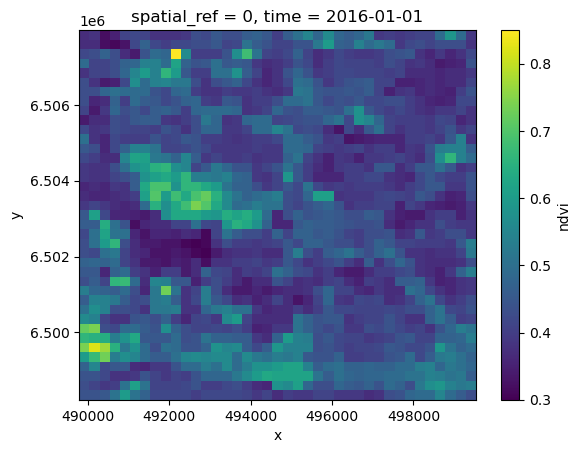

In [51]:
ds.sel(time='2016-01-01')['ndvi'].plot()

In [56]:
# ds.sel(time='2021-01-08')['veg_index'].plot()

## Pre-processing phase

### Group data by month and reduce by median

In [57]:
# take our dask ds and group and reduce dataset in median weeks (26 for one year)
ds = phenolopy.group(ds, group_by='month', reducer='median')

# display dataset
ds

Group dataset interval: month via reducer: median
> Selecting year: 2017 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



<xarray.Dataset>
Dimensions:      (x: 39, y: 39, time: 12)
Coordinates:
  * x            (x) float64 4.899e+05 4.902e+05 ... 4.992e+05 4.994e+05
  * y            (y) float64 6.508e+06 6.508e+06 ... 6.499e+06 6.498e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Data variables:
    veg_index    (time, y, x) float32 0.38 0.38 0.365 0.39 ... 0.55 0.55 0.56

### Remove outliers from dataset on per-pixel basis

In [17]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, method='median', user_factor=2, z_pval=0.05)

# display dataset
ds

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



<xarray.Dataset>
Dimensions:      (time: 12, y: 1211, x: 1115)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(11, 1211, 1115), meta=np.ndarray>

### Resample dataset down to weekly medians

In [18]:
# set resample interval now, as a few functions require it
interval = '2W'

# correct last datetime value in dataset to ensure resample is accurate
ds = phenolopy.correct_last_datetime(ds, interval)

# takes our dask ds and resamples data to bi-monthly medians
ds = phenolopy.resample(ds, interval=interval, reducer='median')

# display dataset
ds

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



<xarray.Dataset>
Dimensions:      (y: 1211, x: 1115, time: 27)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
  * time         (time) datetime64[ns] 2021-01-03 2021-01-17 ... 2022-01-02
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(3, 1211, 1115), meta=np.ndarray>

### Interpolate missing (i.e. nan) values linearly

In [19]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and interpolates missing values
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')

# remove non-dominant year if exists (by-product of resampling for 1W and 2W)
ds = phenolopy.remove_non_dominant_year(ds)

# display dataset
ds

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


<xarray.Dataset>
Dimensions:      (time: 26, y: 1211, x: 1115)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
  * time         (time) datetime64[ns] 2021-01-03 2021-01-17 ... 2021-12-19
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(26, 1211, 1115), meta=np.ndarray>

### Smooth data on per-pixel basis

In [20]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and smooth using savitsky golay filter
ds = phenolopy.smooth(ds=ds, method='savitsky', window_length=3, polyorder=1)

# display dataset
ds

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



<xarray.Dataset>
Dimensions:      (y: 1211, x: 1115, time: 26)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
  * time         (time) datetime64[ns] 2021-01-03 2021-01-17 ... 2021-12-19
    spatial_ref  int32 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(26, 1211, 1115), meta=np.ndarray>

## Calculate number of seasons (optional)

In [21]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and calculate number of seasons (num of major peaks) per-pixel
da_num_seasons = phenolopy.calc_num_seasons(ds=ds)

# display dataset
da_num_seasons

Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!



<xarray.DataArray 'num_seasons' (y: 1211, x: 1115)>
dask.array<transpose, shape=(1211, 1115), dtype=int16, chunksize=(1211, 1115), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 dask.array<chunksize=(), meta=np.ndarray>

## Calculate Phenometrics

In [22]:
# compute
ds = ds.compute()
ds

/env/lib/python3.10/site-packages/dask/utils.py:71: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.Dataset>
Dimensions:      (y: 1211, x: 1115, time: 26)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
  * time         (time) datetime64[ns] 2021-01-03 2021-01-17 ... 2021-12-19
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 0.1341 0.139 0.1301 ... 0.08327 0.09934

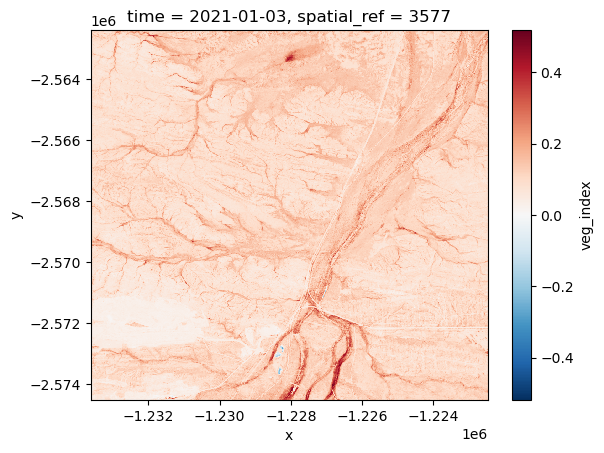

In [24]:
ds.sel(time='2021-01-03')['veg_index'].plot()

In [25]:
# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(da=ds['veg_index'], 
                                        peak_metric='pos', 
                                        base_metric='vos', 
                                        method='seasonal_amplitude', 
                                        factor=0.2, 
                                        thresh_sides='two_sided', 
                                        abs_value=0.1)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


> Calculating end of season (eos) times via method: seasonal_amplitude.
> Success!

Beginning calculation of length of season (los) values (times not possible).
> Calculating length of season (los) values.
> Success!

Beginning calculation of rate of increase (roi) values (times not possible).
> Calculating rate of increase (roi) values.
> Success!

Beginning calculation of rate of decrease (rod) values (times not possible).
> Calculating rate of decrease (rod) values.
> Success!

Beginning calculation of long integral of season (lios) values (times not possible).
> Calculating long integral of season (lios) values.


/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


> Success!

Beginning calculation of short integral of season (sios) values (times not possible).
> Calculating short integral of season (sios) values.
> Success!

Beginning calculation of long integral of total (liot) values (times not possible).
> Calculating long integral of total (liot) values.
> Success!

Beginning calculation of short integral of total (siot) values (times not possible).
> Calculating short integral of total (siot) values.
> Success!



MergeError: conflicting values for variable 'time' on objects to be combined. You can skip this check by specifying compat='override'.

### Debug

In [29]:
import os, sys
from collections import Counter
import xarray as xr
import numpy as np
import pandas as pd
import math
import dask
from datetime import datetime, timedelta
from scipy.stats import zscore
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import gaussian_filter
from statsmodels.tsa.seasonal import STL as stl
from datacube.utils.geometry import assign_crs

In [43]:
da=ds['veg_index'].copy()
peak_metric='pos'
base_metric='vos' 
method='seasonal_amplitude'
factor=0.2
thresh_sides='two_sided'
abs_value=0.1

In [44]:
from phenolopy import *

In [45]:
# notify user
print('Initialising calculation of phenometrics.\n')

# check if dask - not yet supported
if dask.is_dask_collection(da):
    raise TypeError('Dask arrays not yet supported. Please compute first.')

# check if dataset type
if type(da) != xr.DataArray:
    raise TypeError('> Not a data array. Please provide a xarray data array.')

# check if max metric parameters supported
if peak_metric not in ['pos', 'mos']:
    raise ValueError('> The peak_metric parameter must be either pos or mos.')

# check if min metric parameters supported
if base_metric not in ['bse', 'vos']:
    raise ValueError('> The base_metric parameter must be either bse or vos.')

# create template dataset to hold phenometrics
# NOTE: no longer required

# get crs info before work
crs = extract_crs(da=ds_raw)

# take a mask of all-nan slices for clean up at end and set all-nan to 0s
da_all_nan_mask = da.isnull().all('time')
da = da.where(~da_all_nan_mask, 0.0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> Success!



In [48]:
# notify user
print('Beginning calculation of phenometrics. This can take awhile - please wait.\n')

# calc peak of season (pos) values and times
da_pos_values, da_pos_times = get_pos(da=da)

# calc valley of season (vos) values and times
da_vos_values, da_vos_times = get_vos(da=da)

# calc middle of season (mos) value (time not possible)
da_mos_values = get_mos(da=da, da_peak_times=da_pos_times)

# calc base (bse) values (time not possible).
da_bse_values = get_bse(da=da, da_peak_times=da_pos_times)

# calc amplitude of season (aos) values (time not possible). takes peak and base arrays
if peak_metric == 'pos' and base_metric == 'bse':
    da_aos_values = get_aos(da_peak_values=da_pos_values, da_base_values=da_bse_values)
elif peak_metric == 'pos' and base_metric == 'vos':
    da_aos_values = get_aos(da_peak_values=da_pos_values, da_base_values=da_vos_values)
elif peak_metric == 'mos' and base_metric == 'bse':
    da_aos_values = get_aos(da_peak_values=da_mos_values, da_base_values=da_bse_values)
elif peak_metric == 'mos' and base_metric == 'vos':
    da_aos_values = get_aos(da_peak_values=da_mos_values, da_base_values=da_vos_values)

# calc start of season (sos) values and times. takes peak, base metrics and factor
if base_metric == 'bse':
    da_sos_values, da_sos_times = get_sos(da=da, da_peak_times=da_pos_times, da_base_values=da_bse_values,
                                          da_aos_values=da_aos_values, method=method, factor=factor,
                                          thresh_sides='two_sided', abs_value=abs_value)
elif base_metric == 'vos':
    da_sos_values, da_sos_times = get_sos(da=da, da_peak_times=da_pos_times, da_base_values=da_vos_values,
                                          da_aos_values=da_aos_values, method=method, factor=factor,
                                          thresh_sides='two_sided', abs_value=abs_value)   

# calc end of season (eos) values and times. takes peak, base metrics and factor
if base_metric == 'bse':
    da_eos_values, da_eos_times = get_eos(da=da, da_peak_times=da_pos_times, da_base_values=da_bse_values,
                                          da_aos_values=da_aos_values, method=method, factor=factor,
                                          thresh_sides='two_sided', abs_value=abs_value)
elif base_metric == 'vos':
    da_eos_values, da_eos_times = get_eos(da=da, da_peak_times=da_pos_times, da_base_values=da_vos_values,
                                          da_aos_values=da_aos_values, method=method, factor=factor,
                                          thresh_sides='two_sided', abs_value=abs_value)


# calc length of season (los) values (time not possible). takes sos and eos
da_los_values = get_los(da=da, da_sos_times=da_sos_times, da_eos_times=da_eos_times)

# calc rate of icnrease (roi) values (time not possible). takes peak array (pos)
da_roi_values = get_roi(da_peak_values=da_pos_values, da_peak_times=da_pos_times,
                        da_sos_values=da_sos_values, da_sos_times=da_sos_times)

# calc rate of decrease (rod) values (time not possible). takes peak array (pos)
da_rod_values = get_rod(da_peak_values=da_pos_values, da_peak_times=da_pos_times,
                        da_eos_values=da_eos_values, da_eos_times=da_eos_times)

# calc long integral of season (lios) values (time not possible)
da_lios_values = get_lios(da=da, da_sos_times=da_sos_times, da_eos_times=da_eos_times)

# calc short integral of season (sios) values (time not possible)
if base_metric == 'bse':
    da_sios_values = get_sios(da=da, da_sos_times=da_sos_times, 
                              da_eos_times=da_eos_times,
                              da_base_values=da_bse_values)
elif base_metric == 'vos':
    da_sios_values = get_sios(da=da, da_sos_times=da_sos_times, 
                              da_eos_times=da_eos_times,
                              da_base_values=da_vos_values)   

# calc long integral of total (liot) values (time not possible)
da_liot_values = get_liot(da=da)

# calc short integral of total (siot) values (time not possible)
if base_metric == 'bse':
    da_siot_values = get_siot(da=da, da_base_values=da_bse_values)
elif base_metric == 'vos':
    da_siot_values = get_siot(da=da, da_base_values=da_vos_values)

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and times.
> Calculating start of season (sos) values via method: seasonal_amplitude.
> Calculating start of season (sos) times via method: seasonal_amplitude

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


> Calculating end of season (eos) times via method: seasonal_amplitude.
> Success!

Beginning calculation of length of season (los) values (times not possible).
> Calculating length of season (los) values.
> Success!

Beginning calculation of rate of increase (roi) values (times not possible).
> Calculating rate of increase (roi) values.
> Success!

Beginning calculation of rate of decrease (rod) values (times not possible).
> Calculating rate of decrease (rod) values.
> Success!

Beginning calculation of long integral of season (lios) values (times not possible).
> Calculating long integral of season (lios) values.


/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


> Success!

Beginning calculation of short integral of season (sios) values (times not possible).
> Calculating short integral of season (sios) values.
> Success!

Beginning calculation of long integral of total (liot) values (times not possible).
> Calculating long integral of total (liot) values.
> Success!

Beginning calculation of short integral of total (siot) values (times not possible).
> Calculating short integral of total (siot) values.
> Success!



In [49]:
# create data array list
da_list = [
    da_pos_values, 
    da_pos_times,
    da_mos_values, 
    da_vos_values, 
    da_vos_times,
    da_bse_values,
    da_aos_values,
    da_sos_values, 
    da_sos_times,
    da_eos_values, 
    da_eos_times,
    da_los_values,
    da_roi_values,
    da_rod_values,
    da_lios_values,
    da_sios_values,
    da_liot_values,
    da_siot_values
]

In [62]:
# da_pos_times = da_pos_times.drop('time')

In [84]:
# for d in da_list:
#     if 'time' in d.coords:
#         d = d.drop('time')

In [85]:
for d in da_list:
    if 'time' in d.coords:
        print(d.name)

pos_times
vos_times
sos_values
sos_times
eos_values
eos_times
roi_values
rod_values


In [87]:
# [d.shape for d in da_list]

In [88]:
# combine data arrays into one dataset
ds_phenos = xr.merge(da_list, compat='override')

In [90]:
# set original all nan pixels back to nan
ds_phenos = ds_phenos.where(~da_all_nan_mask)

# add crs metadata back onto dataset
ds_phenos = add_crs(ds=ds_phenos, crs=crs)

# notify user
print('Phenometrics calculated successfully!')

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Success!

Phenometrics calculated successfully!


## Display phenometric

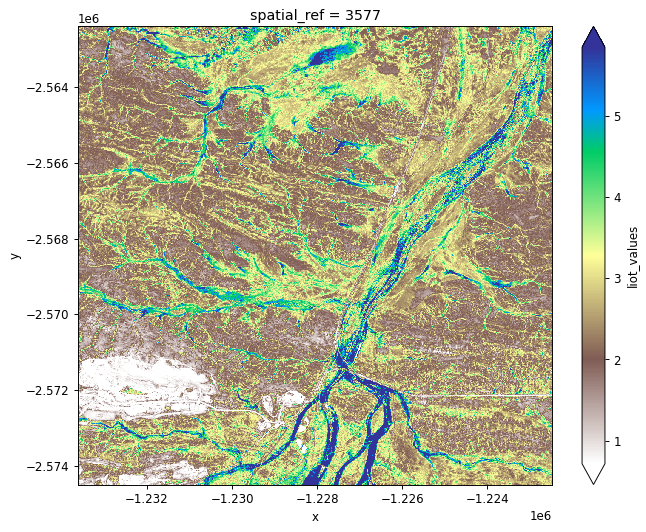

In [91]:
# set the metric you want to view (e.g. pos_values, pos_times, vos_values, vos_times, ect.)
metric_name = 'liot_values'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_phenos[metric_name].plot(robust=True, cmap='terrain_r')